C:\Users\jprob\AppData\Local\Temp\ipykernel_15536\3189693223.py:59: LangChainDeprecationWarning: The class `Neo4jVector` was deprecated in LangChain 0.3.8 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-neo4j package and should be used instead. To use it run `pip install -U :class:`~langchain-neo4j` and import as `from :class:`~langchain_neo4j import Neo4jVector``.
  vector_store = Neo4jVector(


Enhanced Neo4j tools created: 3
  - neo4j_query
  - semantic_similarity_search
  - neo4j_schema
✅ Enhanced search system created with semantic vector search!
📊 Capabilities: Traditional Cypher + Semantic Vector Search + 2-hop Traversal

📊 Enhanced Graph Visualization:


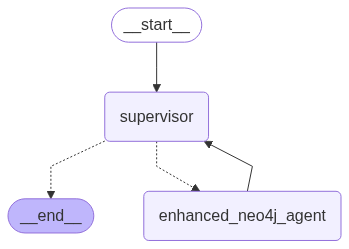


🔍 Enhanced System Ready!
✨ NEW: Semantic vector search with similarity scores
✨ NEW: 2-hop graph traversal for connected data
✨ NEW: Hybrid retrieval combining vectors + graph

Usage: search('your question here')


In [ ]:
# Enhanced GraphRAG Neo4j Agent with Semantic Vector Search
# This notebook extends the original agent with vector similarity search capabilities

import os
from IPython.display import Image, display

from dotenv import load_dotenv
import os
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor

# Original imports
from langchain_community.graphs import Neo4jGraph
from langchain.chains import GraphCypherQAChain
from langchain_core.tools import Tool

# NEW: Vector search imports
from langchain_community.vectorstores import Neo4jVector
from langchain_openai import OpenAIEmbeddings

load_dotenv()

# Environment variables
openai_key = os.getenv("OPENAI_API_KEY")
langchain_key = os.getenv("LANGCHAIN_API_KEY")
neo4j_uri = os.getenv("NEO4J_URI")
neo4j_user = os.getenv("NEO4J_USERNAME")
neo4j_password = os.getenv("NEO4J_PASSWORD")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Enhanced_GraphRAG"

# Initialize model
model = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0,
    max_tokens=1500,  # Increased for more detailed responses
    api_key=openai_key
)

# ============================================================================
# ENHANCED: Create Neo4j tools with Vector Search
# ============================================================================

def create_enhanced_neo4j_tools():
    """Create Neo4j database tools with Text2Cypher AND Vector Search capability."""
    
    # Initialize Neo4j connection (existing)
    graph = Neo4jGraph(
        url=neo4j_uri,
        username=neo4j_user,
        password=neo4j_password
    )
    
    # NEW: Initialize Vector Store for semantic search
    embeddings = OpenAIEmbeddings(openai_api_key=openai_key)
    
    vector_store = Neo4jVector(
        url=neo4j_uri,
        username=neo4j_user,
        password=neo4j_password,
        embedding=embeddings,
        index_name="semantic_concepts_vector_index",  # Your existing index
        node_label="SemanticVector",
        text_node_property="text",
        embedding_node_property="embedding"
    )
    
    # Create Text2Cypher chain (existing)
    cypher_chain = GraphCypherQAChain.from_llm(
        llm=model,
        graph=graph,
        verbose=True,
        return_intermediate_steps=True,
        allow_dangerous_requests=True
    )
    
    def query_neo4j_database(query: str) -> str:
        """
        Query the Neo4j database using natural language.
        Converts natural language questions to Cypher queries and executes them.
        
        Args:
            query: Natural language question about the data in the graph database
            
        Returns:
            String containing the query results and explanation
        """
        try:
            result = cypher_chain.invoke({"query": query})
            
            if "intermediate_steps" in result:
                cypher_query = result["intermediate_steps"][0]["query"]
                response = f"""**Generated Cypher Query:**
```cypher
{cypher_query}
```

**Results:**
{result['result']}"""
            else:
                response = result['result']    
            return response
        except Exception as e:
            return f"Error querying Neo4j database: {str(e)}"
    
    # NEW: Semantic Vector Search Tool
    def semantic_similarity_search(query: str) -> str:
        """
        Search for semantically similar concepts using vector embeddings.
        Then traverse the graph to find connected operational data.
        
        Args:
            query: Natural language query about equipment, maintenance, or processes
            
        Returns:
            String with similar concepts, scores, and connected operational data
        """
        try:
            # Step 1: Vector similarity search
            similar_docs = vector_store.similarity_search_with_score(query, k=3)
            
            if not similar_docs:
                return "No semantically similar concepts found."
            
            response = f"**🔍 Semantic Similarity Search Results for: '{query}'**\n\n"
            
            # Step 2: For each similar concept, do 2-hop graph traversal
            for i, (doc, score) in enumerate(similar_docs, 1):
                concept_id = doc.metadata.get('concept_id', 'Unknown')
                label = doc.metadata.get('label', 'Unknown')
                domain = doc.metadata.get('domain', 'Unknown')
                
                response += f"**{i}. {label}**\n"
                response += f"   - Similarity Score: {score:.4f}\n"
                response += f"   - Concept ID: {concept_id}\n"
                response += f"   - Domain: {domain}\n"
                
                # 2-hop graph traversal query
                traversal_query = """
                MATCH (sv:SemanticVector {concept_id: $concept_id})
                MATCH (sv)-[:VECTOR_REPRESENTATION_OF]->(sc:SemanticConcept)
                
                // 1st hop: Find equipment connected to this concept
                OPTIONAL MATCH (eq:DryPump)-[:HAS_SEMANTIC_TYPE]->(sc)
                
                // 2nd hop: Find operational data connected to equipment
                OPTIONAL MATCH (eq)-[:HAS_RUL_ASSESSMENT]->(rul:RemainingUsefulLife)
                OPTIONAL MATCH (eq)-[:HAS_FAILURE_PREDICTION]->(pred:ThirtyDayFailureProbability)
                OPTIONAL MATCH (eq)-[:SERVES]->(chamber:ProcessChamber)
                OPTIONAL MATCH (chamber)-[:PART_OF]->(tool:SemiconductorTool)
                
                // Also get semantic context
                OPTIONAL MATCH (sc)-[:HAS_MEANING_IN_CONTEXT]->(ctx:SemanticContext)
                
                RETURN sc.label as concept_label,
                       sc.definition as concept_definition,
                       sc.domain as concept_domain,
                       eq.pumpIdentifier as equipment_id,
                       eq.isOperational as is_operational,
                       eq.pumpingSpeed as pumping_speed,
                       rul.healthIndex as health_index,
                       pred.riskScore as risk_score,
                       chamber.chamberId as chamber_id,
                       tool.toolId as tool_id,
                       ctx.businessContext as business_context
                """
                
                # Execute traversal
                with graph._driver.session() as session:
                    result = session.run(traversal_query, concept_id=concept_id)
                    records = list(result)
                    
                    if records:
                        for record in records:
                            if record['equipment_id']:
                                response += f"   - **Connected Equipment**: {record['equipment_id']}\n"
                                response += f"     * Operational: {record['is_operational']}\n"
                                if record['pumping_speed']:
                                    response += f"     * Pumping Speed: {record['pumping_speed']}\n"
                                if record['health_index']:
                                    response += f"     * Health Index: {record['health_index']}\n"
                                if record['risk_score']:
                                    response += f"     * Risk Score: {record['risk_score']}\n"
                                if record['chamber_id']:
                                    response += f"     * Serves Chamber: {record['chamber_id']}\n"
                                if record['tool_id']:
                                    response += f"     * Part of Tool: {record['tool_id']}\n"
                            
                            if record['business_context']:
                                response += f"   - **Business Context**: {record['business_context'][:100]}...\n"
                    else:
                        response += f"   - No connected operational data found\n"
                
                response += "\n"
            
            return response
            
        except Exception as e:
            return f"Error in semantic similarity search: {str(e)}"
    
    def get_database_schema(query: str) -> str:  # ✅ Accepts query parameter
        """
        Get the schema information of the Neo4j database.
        Returns node labels, relationship types, and property information.
        """
        try:
            schema_info = graph.get_schema()
            return f"Neo4j Database Schema:\n{schema_info}"
        except Exception as e:
            return f"Error retrieving database schema: {str(e)}"
    
    # Create tools (existing + new)
    neo4j_query_tool = Tool(
        name="neo4j_query",
        description="Query the Neo4j graph database using natural language. Use this for specific Cypher queries, exact matches, and structured data retrieval.",
        func=query_neo4j_database
    )
    
    # NEW: Semantic search tool
    semantic_search_tool = Tool(
        name="semantic_similarity_search",
        description="Search for semantically similar concepts using vector embeddings, then traverse connected operational data. Use this for conceptual queries about equipment types, maintenance strategies, or business domains. Shows similarity scores and 2-hop graph connections.",
        func=semantic_similarity_search
    )
    
    schema_tool = Tool(
        name="neo4j_schema",
        description="Get the schema information of the Neo4j database including node types, relationships, and properties. Use this to understand the database structure.",
        func=get_database_schema
    )
    
    return [neo4j_query_tool, semantic_search_tool, schema_tool]

# ============================================================================
# ENHANCED: Updated Agent Prompt with Vector Search Capabilities
# ============================================================================

def create_enhanced_neo4j_agent_prompt(tools):
    """Create enhanced Neo4j agent prompt with vector search capabilities."""
    
    # Generate tool descriptions
    tool_descriptions = []
    for tool in tools:
        tool_desc = f"- {tool.name}: {tool.description}"
        tool_descriptions.append(tool_desc)
    
    tools_text = "\n".join(tool_descriptions)
    
    neo4j_prompt = ChatPromptTemplate.from_messages([
        ("system", f"""You are a specialized Neo4j Graph Database ReAct agent with ENHANCED semantic vector search capabilities. You excel at both traditional graph queries and semantic similarity search for predictive maintenance insights.

AVAILABLE TOOLS:
{tools_text}

YOUR ENHANCED EXPERTISE:
- Converting natural language to Cypher queries
- **NEW: Semantic vector similarity search with business context**
- **NEW: Hybrid retrieval combining vectors + graph traversal**
- Understanding graph database schemas and structures
- Finding patterns and relationships in graph data
- Extracting entity information and connections
- **NEW: Maintenance domain knowledge through semantic concepts**

TOOL SELECTION STRATEGY:

**Use semantic_similarity_search when:**
- Questions about equipment types, domains, or categories
- Conceptual queries (e.g., "vacuum technology", "maintenance strategies")
- Business impact or domain knowledge questions
- Finding semantically related equipment or processes
- Exploring maintenance concepts and approaches

**Use neo4j_query when:**
- Specific equipment queries (exact IDs, properties)
- Numerical data retrieval (speeds, pressures, dates)
- Relationship traversals with known starting points
- Complex multi-step Cypher queries
- Aggregations and calculations

**Use neo4j_schema when:**
- Understanding database structure
- Complex query planning
- Exploring available data types

REACT METHODOLOGY:

1. THOUGHT: Analyze the request type
   - Is this a conceptual/semantic query? → Use semantic_similarity_search
   - Is this a specific data query? → Use neo4j_query
   - Do I need to understand the structure? → Use neo4j_schema

2. ACTION: Execute the appropriate tool
   - Semantic searches show similarity scores and 2-hop connections
   - Traditional queries show Cypher and direct results
   - Always prioritize user intent and question type

3. OBSERVATION: Analyze results
   - For semantic results: Review similarity scores and connected data
   - For Cypher results: Examine generated queries and returned data
   - Look for patterns and insights across both approaches

4. DECISION: Continue or conclude
   - If information is sufficient: Provide FINAL ANSWER with insights
   - If more detail needed: Use complementary tools
   - Maximum 3 tool calls for efficiency

IMPORTANT RULES:
- **ALWAYS explain why you chose a particular tool**
- **Include similarity scores in semantic search results**
- **Highlight connections between semantic concepts and operational data**
- Provide context about both vector similarity and graph relationships
- Focus on predictive maintenance insights and business value
- Include relevant technical details (health indices, risk scores, etc.)"""),
        
        ("placeholder", "{messages}"),
    ])
    
    return neo4j_prompt

# ============================================================================
# ENHANCED: Supervisor with Vector Search Awareness
# ============================================================================

def create_enhanced_supervisor_prompt(agents):
    """Create enhanced supervisor prompt with vector search awareness."""
    
    agent_descriptions = []
    for agent_name, agent_info in agents.items():
        agent_descriptions.append(f"- {agent_name}: {agent_info['description']}")
    
    agents_text = "\n".join(agent_descriptions)
    
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", f"""You are a Supervisor Agent coordinating ENHANCED graph database operations with semantic vector search capabilities.

AVAILABLE AGENTS:
{agents_text}

YOUR ENHANCED RESPONSIBILITIES:
1. ANALYZE requests for both semantic and structural information needs
2. ROUTE queries to the enhanced neo4j agent with vector search capabilities
3. PROVIDE final consolidated answers combining semantic and graph insights

ENHANCED DECISION FRAMEWORK:
- For conceptual questions about equipment types, maintenance strategies, or domains: Route to neo4j_agent (will use semantic vector search)
- For specific data queries about known equipment or exact values: Route to neo4j_agent (will use traditional Cypher)
- For complex questions needing both approaches: Route to neo4j_agent (will use hybrid approach)
- For completed tasks: Use FINISH

COORDINATION RULES:
- Trust the agent's tool selection expertise (semantic vs. traditional queries)
- Expect to see both similarity scores and graph traversal results
- Synthesize semantic insights with operational data
- Highlight business value and maintenance implications
- Accept useful partial results when complete info unavailable

When routing, be clear about what type of information is needed and trust the agent to select the best approach."""),
        
        ("placeholder", "{messages}"),
    ])
    
    return supervisor_prompt

# ============================================================================
# ENHANCED: System Creation with Vector Search
# ============================================================================

def create_enhanced_search_system():
    """Create the enhanced search system with vector capabilities."""
    
    # Create enhanced Neo4j tools (now includes vector search)
    enhanced_neo4j_tools = create_enhanced_neo4j_tools()
    print(f"Enhanced Neo4j tools created: {len(enhanced_neo4j_tools)}")
    for tool in enhanced_neo4j_tools:
        print(f"  - {tool.name}")
    
    # Create enhanced Neo4j agent with vector search capabilities
    enhanced_neo4j_prompt = create_enhanced_neo4j_agent_prompt(enhanced_neo4j_tools)
    enhanced_neo4j_agent = create_react_agent(
        model=model,
        tools=enhanced_neo4j_tools,
        prompt=enhanced_neo4j_prompt,
        name="enhanced_neo4j_agent"
    )
    
    # Define enhanced agents dictionary
    agents = {
        "enhanced_neo4j_agent": {
            "agent": enhanced_neo4j_agent,
            "description": "Handles both traditional Cypher queries AND semantic vector similarity search. Combines graph traversal with semantic understanding for comprehensive predictive maintenance insights. Can find equipment by semantic similarity and provide business context."
        }
    }
    
    # Create enhanced supervisor
    enhanced_supervisor_prompt = create_enhanced_supervisor_prompt(agents)
    agent_list = [info["agent"] for name, info in agents.items()]
    
    supervisor = create_supervisor(
        model=model,
        agents=agent_list,
        prompt=enhanced_supervisor_prompt
    )
    
    # Compile graph
    compiled_graph = supervisor.compile()
    
    # Add configuration
    compiled_graph.config = {
        "recursion_limit": 50,
        "max_execution_time": 300
    }
    
    print("✅ Enhanced search system created with semantic vector search!")
    print("📊 Capabilities: Traditional Cypher + Semantic Vector Search + 2-hop Traversal")
    
    return compiled_graph

# ============================================================================
# INITIALIZE ENHANCED SYSTEM
# ============================================================================

# Initialize the enhanced system
enhanced_search_system = create_enhanced_search_system()

# Visualize the graph
print("\n📊 Enhanced Graph Visualization:")
try:
    display(Image(enhanced_search_system.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Visualization error: {e}")

# Enhanced search function
def search(query: str):
    """Execute search query through the enhanced system."""
    result = enhanced_search_system.invoke({"messages": [{"role": "user", "content": query}]})
    return result["messages"][-1].content

print("\n🔍 Enhanced System Ready!")
print("✨ NEW: Semantic vector search with similarity scores")
print("✨ NEW: 2-hop graph traversal for connected data")
print("✨ NEW: Hybrid retrieval combining vectors + graph")
print("\nUsage: search('your question here')")


In [6]:
print("\n" + "-"*50)
print("🔍 Original Test 1: Database Schema")
print("-"*50)
schema_result = search("What's the current database schema?")
print("Schema Test Result:")
print(schema_result[:500] + "..." if len(schema_result) > 500 else schema_result)


--------------------------------------------------
🔍 Original Test 1: Database Schema
--------------------------------------------------
Schema Test Result:
It seems there was a technical issue retrieving the current database schema. If you have other questions or need assistance with a different query, feel free to ask!


In [4]:
result = search("What's the current database schema?")
print("Schema Test Result:")
print(result)



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
CALL db.schema.visualization()

Full Context:
[{'nodes': [{'name': 'SemiconductorTool', 'indexes': [], 'constraints': []}, {'name': 'ProcessRecipe', 'indexes': [], 'constraints': []}, {'name': 'MIMOSA', 'indexes': [], 'constraints': []}, {'name': 'RemainingUsefulLife', 'indexes': [], 'constraints': []}, {'name': 'WeibullSurvivalFunction', 'indexes': [], 'constraints': []}, {'name': 'Fab', 'indexes': [], 'constraints': []}, {'name': 'FabArea', 'indexes': [], 'constraints': []}, {'name': 'OntologyTerm', 'indexes': ['ontologySource'], 'constraints': ["Constraint( id=5, name='ontology_term_uri_unique', type='NODE PROPERTY UNIQUENESS', schema=(:OntologyTerm {uri}), ownedIndex=4 )"]}, {'name': 'DryPump', 'indexes': [], 'constraints': []}, {'name': 'SOSA', 'indexes': [], 'constraints': []}, {'name': 'ProcessChamber', 'indexes': [], 'constraints': []}, {'name': 'BlendedHazardFunction', 'indexes': [], 'constraints': []}, {'na